# Augment Bounding Boxes

`imgaug` has native support for bounding boxes and their augmentation. They are represented via their top-left and bottom-right corner coordinates, both as absolute values and with sub-pixel accuracy.

In `imgaug`, bounding boxes are only affected by augmenters changing the geometry of images. This is the case for e.g. horizontal flips or affine transformations. They are not affected by other methods, such as gaussian noise.

Two classes are provided for bounding box augmentation in `imgaug`, listed in the following sections.

## API: BoundingBox

`imgaug.augmentables.bbs.BoundingBox(x1, y1, x2, y2, label=None)`: Container for a single bounding box, defined based on its top-left and bottom-right corners, each given as x- and y- pixel coordinates (floats, i.e. sub-pixel accurate).
  * Important properties offered by `BoundingBox` are: `.x1`, `.y1`, `.x2`, `.y2`, `.height`, `.width`, `.area`, `.center_x`, `.center_y`.
  * Important methods offered by `BoundingBox` are:
    * `project(from_shape, to_shape)`: Projects the bounding box coordinates from one image shape to another.
    * `extend([all_sides], [top], [right], [bottom], [left])`: Increases the size of the bounding boxes by pixel values along given sides.
    * `intersection(other, [default])`: Returns the intersection bounding box of this bounding box and another one.
    * `union(other)`: Analogous to `intersection()`, returns the union.
    * `iou(other)`: Computes the IoU of this bounding box and another one.
    * `is_fully_within_image(image)`: Determines whether all bounding box coordinates are inside the image plane.
    * `is_partly_within_image(image)`: Determines whether at least parts of the bounding box are inside the image plane.
    * `clip_out_of_image(image)`: Clips off all parts of the bounding box that are outside of the image plane.
    * `shift([top], [right], [bottom], [left])`: Moves the bounding box.
    * `draw_on_image(image, [color], [alpha], [size], [copy], [raise_if_out_of_image])`: Draws the bounding box on an image.
    * `extract_from_image(image, [pad], [pad_max], [prevent_zero_size])`: Extracts the pixels contained in a bounding box from an image.

## API: BoundingBoxesOnImage

`imgaug.augmentables.bbs.BoundingBoxesOnImage(bounding_boxes, shape)`: Container for a list of bounding boxes placed on an image. The `shape` argument denotes the shape of the image on which the bounding boxes are placed. It is required to make sure that augmentations based on the image size are aligned between the image and the bounding boxes placed on it (e.g. cropping).
  * Important methods offered by `BoundingBoxesOnImage` are:
    * `on(image)`: Projects the bounding box(es) onto another image.
    * `from_xyxy_array(xyxy, shape)`: Creates a `BoundingBoxesOnImage` instance from an `(N,4)` numpy array.
    * `to_xyxy_array([dtype])`: Converts the instance to an `(N,4)` numpy array.
    * `draw_on_image([color], [alpha], [size], [copy], [raise_if_out_of_image])`: Draws all bounding boxes onto an image.
    * `remove_out_of_image([fully], [partly])`: Removes bounding box that are fully or at least partially outside of the image plane.
    * `clip_out_of_image()`: Calls `clip_out_of_image()` on all bounding boxes.
    * `shift([top], [right], [bottom], [left])`: Calls `shift()` on all bounding boxes.

## API: Methods

Bounding boxes can be augmented using the method `augment(images=..., bounding_boxes=...)`. Alternatively, `augment_bounding_boxes()` can be used, which accepts either a single instance of `BoundingBoxesOnImage` or a list of that class.

## API: More

Most of the mentioned methods are explained below. The [API](https://imgaug.readthedocs.io/en/latest/source/api.html) also contains further details. See e.g. [BoundingBox](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.bbs.BoundingBox), [BoundingBoxesOnImage](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.bbs.BoundingBoxesOnImage), [imgaug.augmenters.meta.Augmenter.augment()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment) and [imgaug.augmenters.meta.Augmenter.augment_bounding_boxes()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment_bounding_boxes).

## Example

Let's try a simple example for bounding box augmentation. We load one image, place two bounding boxes on it and then augment the data using an affine transformation.

First, we load and visualize the data:

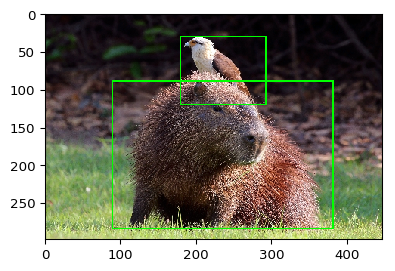

In [1]:
import imageio
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
ia.seed(1)

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/8/8e/Yellow-headed_caracara_%28Milvago_chimachima%29_on_capybara_%28Hydrochoeris_hydrochaeris%29.JPG")
image = ia.imresize_single_image(image, (298, 447))

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=0.2*447, x2=0.85*447, y1=0.3*298, y2=0.95*298),
    BoundingBox(x1=0.4*447, x2=0.65*447, y1=0.1*298, y2=0.4*298)
], shape=image.shape)

ia.imshow(bbs.draw_on_image(image, size=2))

The next step is to define the augmentations that we want to apply. We choose a simple contrast augmentation (affects only the image) and an affine transformation (affects image and bounding boxes).

In [2]:
from imgaug import augmenters as iaa 
ia.seed(1)

seq = iaa.Sequential([
    iaa.GammaContrast(1.5),
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8)
])

Now we augment both the image and the bounding boxes on it. We can use `seq.augment(...)` for that or its shortcut `seq(...)`:

In [3]:
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

Note that if we wanted to augment several images, we would have used something like `seq(images=[image1, image2, ...], bounding_boxes=[bbs1, bbs2, ...])`. The method is fairly flexible and can also handle bounding boxes that differ from `BoundingBoxesOnImage`, e.g. a `(N,4)` array per image denoting `(x1,y1,x2,y2)` of each bounding box. Make sure though to call the method once for both images and bounding boxes, not twice (once for images, once for bounding boxes) as then different random values would be sampled per call and the augmentations would end being unaligned.

Now that we have our data augmented we can visualize it again:

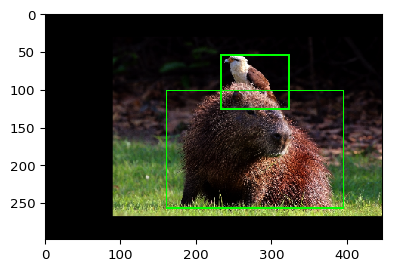

In [4]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

## Problems Introduced by Rotation of 45°

Let's try a different augmentation technique. This time we apply an affine transformation consisting only of rotation.

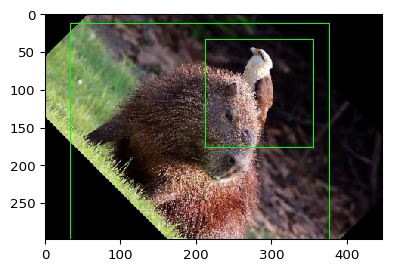

In [5]:
image_aug, bbs_aug = iaa.Affine(rotate=45)(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug))

You may now be inclined to say that these augmentations look off and that something must have went wrong. But the outputs are actually correct and show a corner case of bounding box augmentation -- or, why you should avoid 45° rotations. The problem originates from non-object pixels being part of the bounding box. After rotation, a new bounding box has to be drawn that incorporates these non-object pixels. The following example visualizes the problem:

/home/aj/software/anaconda3/envs/imgaug37/lib/python3.7/site-packages/imgaug/augmentables/bbs.py:548: DeprecationWarning: Usage of argument 'thickness' in BoundingBox.draw_on_image() is deprecated. The argument was renamed to 'size'.
  "Usage of argument 'thickness' in BoundingBox.draw_on_image() "


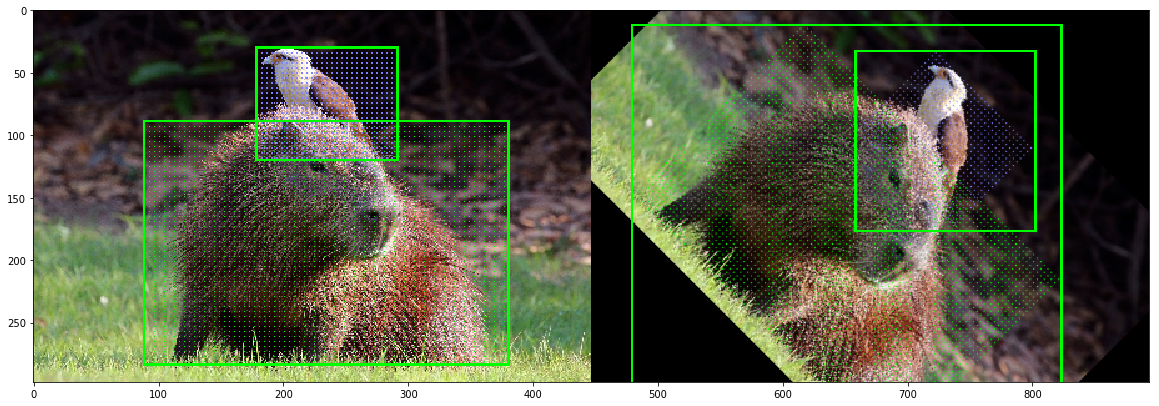

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# highlight the area of each bounding box
image_points = np.copy(image)
colors = [(0, 255, 0), (128, 128, 255)]
for bb, color in zip(bbs.bounding_boxes, colors):
    image_points[bb.y1_int:bb.y2_int:4, bb.x1_int:bb.x2_int:4] = color

# rotate the image with the highlighted bounding box areas
rot = iaa.Affine(rotate=45)
image_points_aug, bbs_aug = rot(image=image_points, bounding_boxes=bbs)

# visualize
side_by_side = np.hstack([
    bbs.draw_on_image(image_points, thickness=2),
    bbs_aug.draw_on_image(image_points_aug, thickness=2)
])
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(side_by_side)

As you can see, the augmented bounding boxes perfectly fit each bounding box's rotated pixels. But due to having to wrap around the pixels furthest to the top/right/bottom/left, the new bounding boxes now also contain large amounts of pixels that were previously not contained in the bounding boxes.

## Drawing

A common operation is to draw bounding boxes on images. The method to do that was already used in the above examples. It offers arguments to control the color, size (i.e. border thickness) and alpha (i.e. opacity) of the drawn bounding boxes. The example below shows their usage.

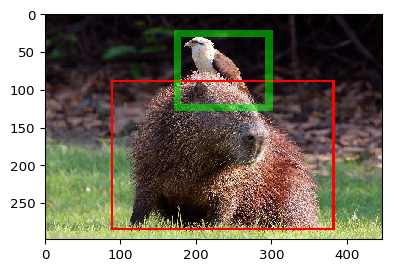

In [7]:
image_bbs = np.copy(image)
image_bbs = bbs.bounding_boxes[0].draw_on_image(image_bbs, color=[255, 0, 0], size=3)
image_bbs = bbs.bounding_boxes[1].draw_on_image(image_bbs, color=[0, 255, 0], size=10, alpha=0.5)
ia.imshow(image_bbs)

## Extracting Image Content, Shifting Bounding Boxes

Another common operation when working with bounding boxes is to extract their corresponding image area. This is trivial when the bounding box is fully within the image plane. If it can also be fully or partially outside of the image plane, the operation becomes a bit more complicated. `BoundingBox` offers `extract_from_image(image)`, which avoids having to deal with such issues. If the bounding box is not fully within the image, it zero-pads the result as necessary reach the bounding box height and width.

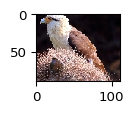

In [8]:
bird = bbs.bounding_boxes[1].extract_from_image(image)
ia.imshow(bird)

Lets extract a larger image area by combining `.extend()` and `.extract_from_image()`:

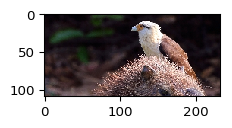

In [9]:
bird = bbs.bounding_boxes[1].extend(all_sides=10, left=100).extract_from_image(image)
ia.imshow(bird)

And now we shift the bounding box partially outside of the image and then extract its content:

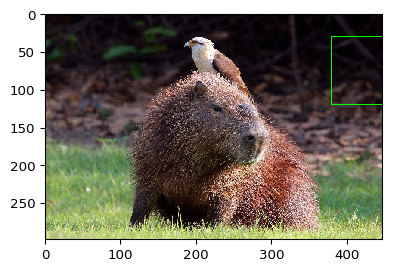

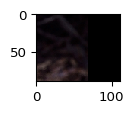

In [10]:
bb = bbs.bounding_boxes[1].shift(left=200)
ia.imshow(bb.draw_on_image(image, size=2))
ia.imshow(bb.extract_from_image(image))

As you can see in the second image, the pixels outside of the image were filled up with zeros. If you don't want that, you can add the argument `pad=False` to deactivate padding. By default, this will still pad to prevent any axis from becoming zero, i.e. you will not get an `(0, 0, 3)` output array. This prevents errors e.g. during plotting. If you prefer to get zero-sized arrays in these situations, simply add `prevent_zero_size=False`.

## Clipping Bounding Boxes

Sometimes you might want to clip off parts of bounding boxes that are outside of the image plane. This can be done using `.clip_out_of_image(<image or shape tuple>)`. The following example first moves one of the bounding boxes partially outside of the image plane and then moves it fully outside of it. Both times the bounding box parts outside of the image plane are clipped of. In the second case, this results in a bounding box with a height and width of zero.

----------------
Shifted by 200px
----------------
BB's area is non-zero


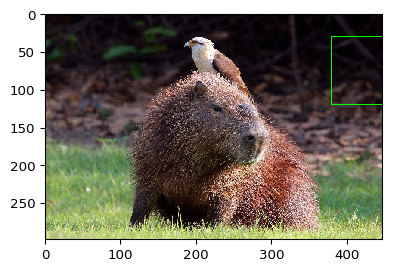

----------------
Shifted by 400px
----------------
BB's area is zero. BB: BoundingBox(x1=447.0000, y1=29.8000, x2=447.0000, y2=119.2000, label=None) vs. image shape: (298, 447, 3)


In [11]:
print("----------------")
print("Shifted by 200px")
print("----------------")
bb = bbs.bounding_boxes[1].shift(left=200).clip_out_of_image(image.shape)
if bb.area > 0:
    print("BB's area is non-zero")
    ia.imshow(bb.draw_on_image(image, thickness=2))
else:
    print("BB's area is zero: BB: %s vs. image shape: %s" % (bb, image.shape))

print("----------------")
print("Shifted by 400px")
print("----------------")
bb = bbs.bounding_boxes[1].shift(left=400).clip_out_of_image(image.shape)
if bb.area > 0:
    print("BB's area is non-zero")
    ia.imshow(bb.draw_on_image(image, thickness=2))
else:
    print("BB's area is zero. BB: %s vs. image shape: %s" % (bb, image.shape))

## Intersection, Union and IoU

Computing the IoU value (intersection over union) is one of the most common tasks when dealing with bounding boxes. `imgaug` offers a method to do that. Additional methods are available to compute intersections and unions of bounding boxes.

Let's start with the intersection, which can be estimated using `BoundingBox.intersection(other_bounding_box)` and returns a new bounding box:

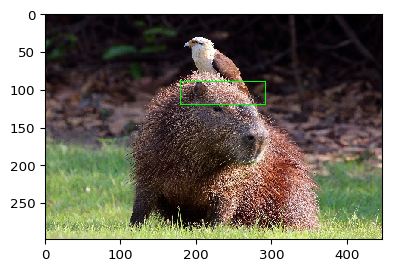

The intersection has a height of 29.8000, width of 111.7500 and an area of 3330.1500


In [12]:
bb_intersection = bbs.bounding_boxes[0].intersection(bbs.bounding_boxes[1])
ia.imshow(bb_intersection.draw_on_image(image))
print("The intersection has a height of %.4f, width of %.4f and an area of %.4f" % (
    bb_intersection.height, bb_intersection.width, bb_intersection.area))

Now the union, which is computed using `BoundingBox.union(other_bounding_box)`:

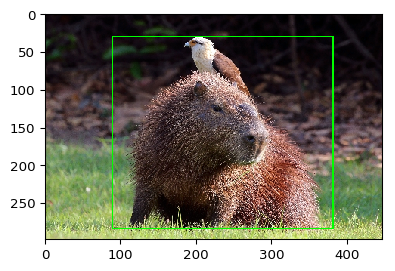

The union has a height of 253.3000, width of 290.5500 and an area of 73596.3150.


In [13]:
bb_union = bbs.bounding_boxes[0].union(bbs.bounding_boxes[1])
ia.imshow(bb_union.draw_on_image(image, thickness=2))
print("The union has a height of %.4f, width of %.4f and an area of %.4f." % (
    bb_union.height, bb_union.width, bb_union.area))

And finally the IoU value, computed as `BoundingBox.iou(other_bounding_box)`. In the code block below we compute it once for our standard example bounding boxes and once after moving one of the two boxes so that they overlap. In the latter case the IoU is higher.

The IoU of the bounding boxes is: 0.0529.
The IoU of the bounding boxes after shifting one box is: 0.1775.


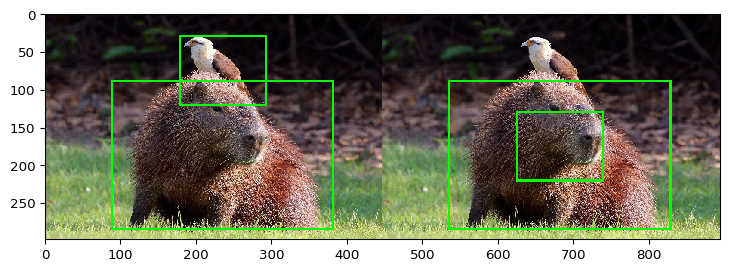

In [14]:
# Shift one BB down so that the BBs overlap
bbs_shifted = ia.BoundingBoxesOnImage([
    bbs.bounding_boxes[0],
    bbs.bounding_boxes[1].shift(top=100),
], shape=bbs.shape)

# Compute IoU without shift
iou = bbs.bounding_boxes[0].iou(bbs.bounding_boxes[1])
print("The IoU of the bounding boxes is: %.4f." % (iou,))

# Compute IoU after shift
iou_shifted = bbs.bounding_boxes[0].iou(bbs_shifted.bounding_boxes[1])
print("The IoU of the bounding boxes after shifting one box is: %.4f." % (iou_shifted,))

# Visualize unshifted and shifted BBs
ia.imshow(
    np.hstack([
        bbs.draw_on_image(image, thickness=3),
        bbs_shifted.draw_on_image(image, thickness=3),
    ])
)

## Projecting bounding boxes onto other images

Sometimes you might have to project bounding boxes from one image onto another. This is particularly important when resizing images. In that case, you can use `BoundingBox.project(from_shape, to_shape)` and `BoundingBoxesOnImage.on(new_image)`. This is shown below. If you have to compensate for padding, use `BoundingBox.shift([top], [right], [bottom], [left])` or the same method for `BoundingBoxesOnImages`. For `BoundingBoxesOnImages`, make sure that you update the `.shape` attribute with the new image shape after padding.

Example for `.project()` and `.on()`:

BoundingBox without changes:


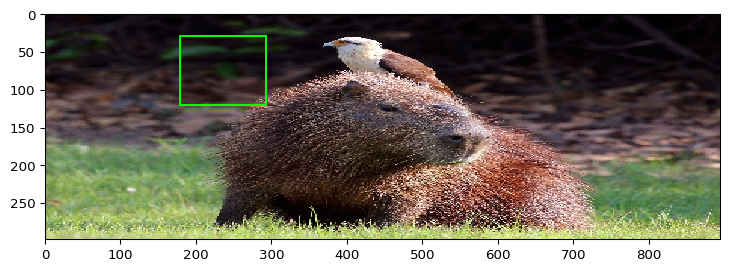

BoundingBox with project(from, to):


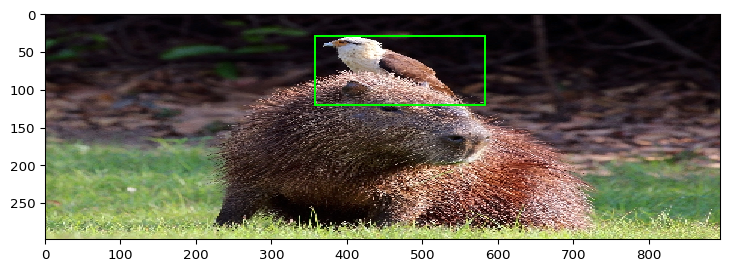

BoundingBoxesOnImage without changes:


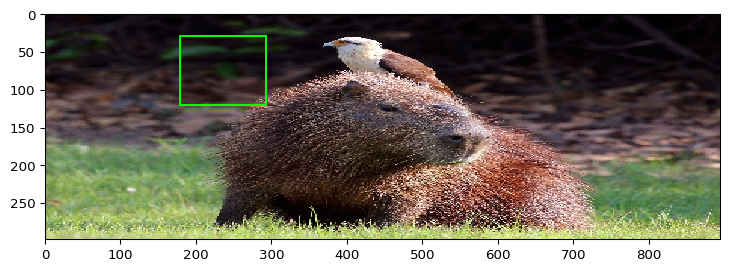

BoundingBoxesOnImage with on(shape):


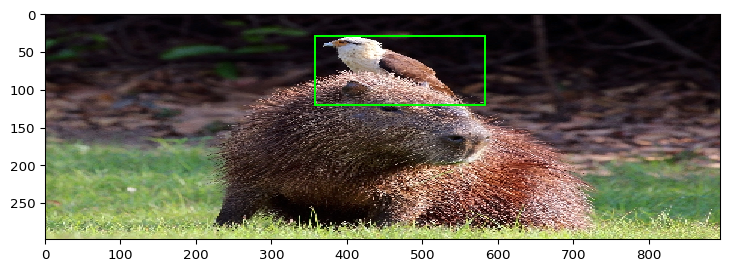

In [15]:
# we limit the example here to the bounding box of the bird
bb_bird = bbs.bounding_boxes[1]
bbsoi_bird = ia.BoundingBoxesOnImage([bbs.bounding_boxes[1]], shape=image.shape)

# lets resize the original image to twice its width
image_larger = ia.imresize_single_image(image, (1.0, 2.0))

# we draw what would happen without any change to the bounding box
print("BoundingBox without changes:")
ia.imshow(bb_bird.draw_on_image(image_larger, thickness=3))

# now the change it using project()
print("BoundingBox with project(from, to):")
ia.imshow(bb_bird.project(from_shape=image.shape, to_shape=image_larger.shape)\
                 .draw_on_image(image_larger, thickness=3))

# and now we do the same two steps for BoundingBoxesOnImage, though here the method is called .on()
print("BoundingBoxesOnImage without changes:")
ia.imshow(bbsoi_bird.draw_on_image(image_larger, thickness=3))

print("BoundingBoxesOnImage with on(shape):")
ia.imshow(bbsoi_bird.on(image_larger.shape).draw_on_image(image_larger, thickness=3))